In [12]:
%matplotlib widget
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import warnings

warnings.filterwarnings("ignore")
import logging

logging.disable(logging.CRITICAL)

Import and process the dataset of Roblox stock information.

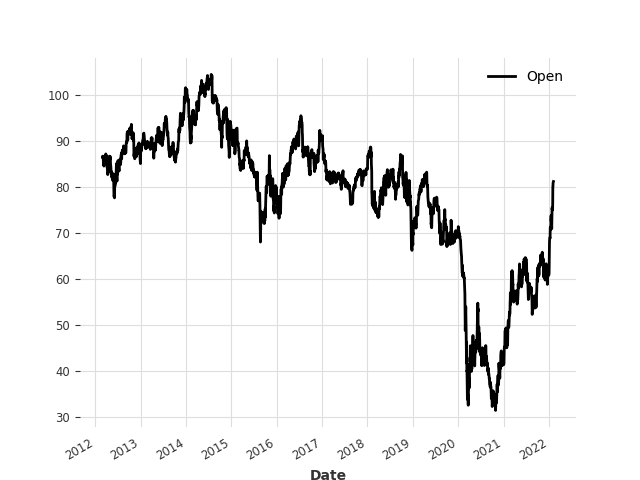

In [14]:
from os.path import abspath
from darts import TimeSeries
from darts.utils.missing_values import fill_missing_values

# Read /data/RBLX.csv as a pandas dataframe
df = pd.read_csv(abspath('../../../data/XOM/XOM.csv'), index_col=0)

# Convert the Data column to datetime
df.index = pd.to_datetime(df.index)

series = TimeSeries.from_dataframe(df, value_cols='Open', freq='B')
series = series.astype(np.float32)

series = fill_missing_values(series, fill="auto")

# Plot the series using a line graph
series.plot()

In [15]:
from darts.dataprocessing.transformers import Scaler

# Find the timestamp of the first 80% of df
first_80_percent = df.index[int(len(df) * 0.8)]

# Create training and test sets
train, val = series.split_after(pd.Timestamp(first_80_percent))

transformer = Scaler()
train_transformed = transformer.fit_transform(train)
val_transformed = transformer.transform(val)
series_transformed = transformer.transform(series)

In [16]:
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from darts.models import NBEATSModel

# stop training when validation loss does not decrease more than 0.05 (`min_delta`) over
# a period of 5 epochs (`patience`)
stopper = EarlyStopping(
    monitor="train_loss",
    patience=5,
    min_delta=0.05,
    mode='min',
)

input_chunk_length = 48
forecast_horizon = 24

model = NBEATSModel(
    input_chunk_length=input_chunk_length,
    output_chunk_length=forecast_horizon,
    generic_architecture=False,
    num_blocks=3,
    num_layers=4,
    layer_widths=512,
    n_epochs=100,
    nr_epochs_val_period=1,
    batch_size=256,
    model_name="XOM-N-BEATS-NonPastCovariate",
    work_dir = abspath('../../../logs/XOM-N-BEATS-Noncovariant'),
    save_checkpoints = True,
    random_state=42
)

In [17]:
model.fit(series=train_transformed, verbose=True)

Epoch 99: 100%|██████████| 8/8 [00:01<00:00,  4.71it/s, loss=0.000973]


In [18]:
from darts.metrics import r2_score

def display_forecast(pred_series, ts_transformed, forecast_type):
    plt.figure(figsize=(8, 5))
    ts_transformed.univariate_component(0).plot(label="actual")
    pred_series.plot(label=("historic " + forecast_type + " forecasts"), color='green')
    plt.title(
        "R2: {}".format(r2_score(ts_transformed.univariate_component(0), pred_series))
    )
    plt.legend()

  0%|          | 0/103 [00:00<?, ?it/s]

Predicting: 8it [00:00, ?it/s]
Predicting: 8it [00:00, ?it/s]
Predicting: 8it [00:00, ?it/s]
Predicting: 8it [00:00, ?it/s]
Predicting: 8it [00:00, ?it/s]
Predicting: 8it [00:00, ?it/s]
Predicting: 8it [00:00, ?it/s]
Predicting: 8it [00:00, ?it/s]
Predicting: 8it [00:00, ?it/s]
Predicting: 8it [00:00, ?it/s]
Predicting: 8it [00:00, ?it/s]
Predicting: 8it [00:00, ?it/s]
Predicting: 8it [00:00, ?it/s]
Predicting: 8it [00:00, ?it/s]
Predicting: 8it [00:00, ?it/s]
Predicting: 8it [00:00, ?it/s]
Predicting: 8it [00:00, ?it/s]
Predicting: 8it [00:00, ?it/s]
Predicting: 8it [00:00, ?it/s]
Predicting: 8it [00:00, ?it/s]
Predicting: 8it [00:00, ?it/s]
Predicting: 8it [00:00, ?it/s]
Predicting: 8it [00:00, ?it/s]
Predicting: 8it [00:00, ?it/s]
Predicting: 8it [00:00, ?it/s]
Predicting: 8it [00:00, ?it/s]
Predicting: 8it [00:00, ?it/s]
Predicting: 8it [00:00, ?it/s]
Predicting: 8it [00:00, ?it/s]
Predicting: 8it [00:00, ?it/s]
Predicting: 8it [00:00, ?it/s]
Predicting: 8it [00:00, ?it/s]
Predicti

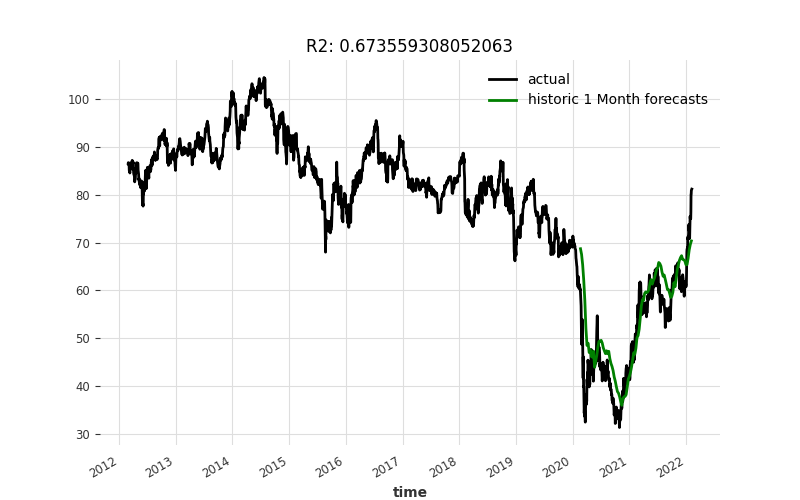

In [19]:
pred_series = model.historical_forecasts(
    series,
    start=pd.Timestamp(first_80_percent),
    forecast_horizon=7,
    stride=5,
    retrain=False,
    verbose=True,
)
display_forecast(pred_series, series, "1 Month")

In [20]:
model.save_model('/Users/aditya/Programming/stock-market-predictions/logs/XOM-N-BEATS-Noncovariant/XOM.pth.tar')